# **Setup**

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
device_name = tf.test.gpu_device_name()
import torch
print(torch.cuda.is_available())
print(device_name)

True
/device:GPU:0


In [2]:
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
import os
import pandas as pd
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D, Reshape, Multiply, Input, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications import InceptionResNetV2

from Tgram import Tgram

# **Load data**

In [4]:
emotions = {
    '0': 'angry',
    '1': 'fear',
    '2': 'happy',
    '3': 'neutral',
    '4': 'sad'
}
emo = {
    value:key
    for key,value in emotions.items()
}
print(emo)

num_classes = len(emotions)

{'angry': '0', 'fear': '1', 'happy': '2', 'neutral': '3', 'sad': '4'}


In [5]:
# import gc

# def load_image_from_row(row, emo):
#     path, label = row['path'], row['label']
#     try:
#         img = Image.open(path)
#         img_array = np.array(img)
#         label_encoded = emo[label]
#         return img_array, label_encoded
#     except FileNotFoundError:
#         print(f'{path}은(는) 존재하지 않습니다.')
#         return None, None

# chunk_size = 10  # 시스템의 메모리에 따라 조정하세요.

# images = []
# labels = []

# for chunk in pd.read_csv('./dataset.csv', chunksize=chunk_size):
#     for _, row in chunk.iterrows():
#         img_array, label_encoded = load_image_from_row(row, emo)
#         if img_array is not None and label_encoded is not None:
#             images.append(img_array)
#             labels.append(label_encoded)
#     del chunk
#     gc.collect()  # 메모리를 명시적으로 해제합니다

# images = np.array(images)
# labels = np.array(labels)

In [6]:
# with open('./pickle_jar/images.pickle', 'wb') as file:
#     pickle.dump(images, file)
# with open('./pickle_jar/labels.pickle', 'wb') as file:
#     pickle.dump(labels, file)

In [7]:
with open('./pickle_jar/images.pickle', 'rb') as file:
    images = pickle.load(file)
with open('./pickle_jar/labels.pickle', 'rb') as file:
    labels = pickle.load(file)

In [8]:
n_samples = labels.shape[0]
print('Total samples:', n_samples)
print('images shape:', images.shape)
print('labels shape:', labels.shape)
del n_samples

Total samples: 424022
images shape: (424022, 96, 96)
labels shape: (424022,)


In [9]:
print(np.unique(labels, return_counts=True))

(array(['0', '1', '2', '3', '4'], dtype='<U1'), array([ 59534, 121435,  59769,  60475, 122809]))


# **Explore data**

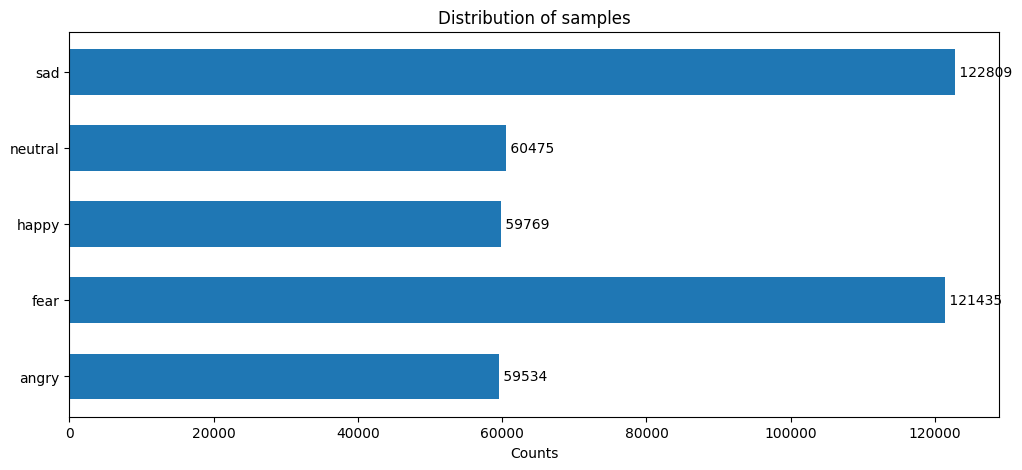

In [10]:
def plot_sample_distribution(labels):
    classes, cnts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12, 5))
    plt.barh(list(emotions.values()), cnts, height=0.6)
    for i, v in enumerate(cnts):
        plt.text(v, i, ' '+str(v), va='center')
    plt.xlabel('Counts')
    plt.title("Distribution of samples")

plot_sample_distribution(labels)

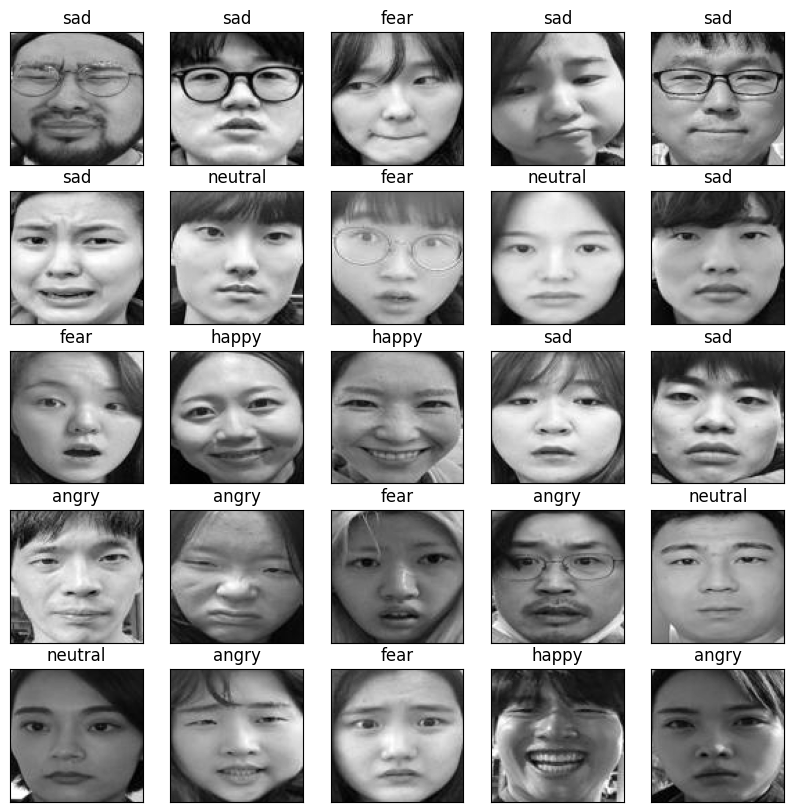

In [11]:
def show_images(images, labels, col=5):
    n = images.shape[0]
    row = int(np.ceil(n / col))
    fig = plt.figure(figsize=(2*col, 2*row))
    for i in range(n):
        fig.add_subplot(row, col, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(emotions[labels[i]])
        plt.xticks([]), plt.yticks([])
    plt.show()

show_images(images[:25], labels[:25])

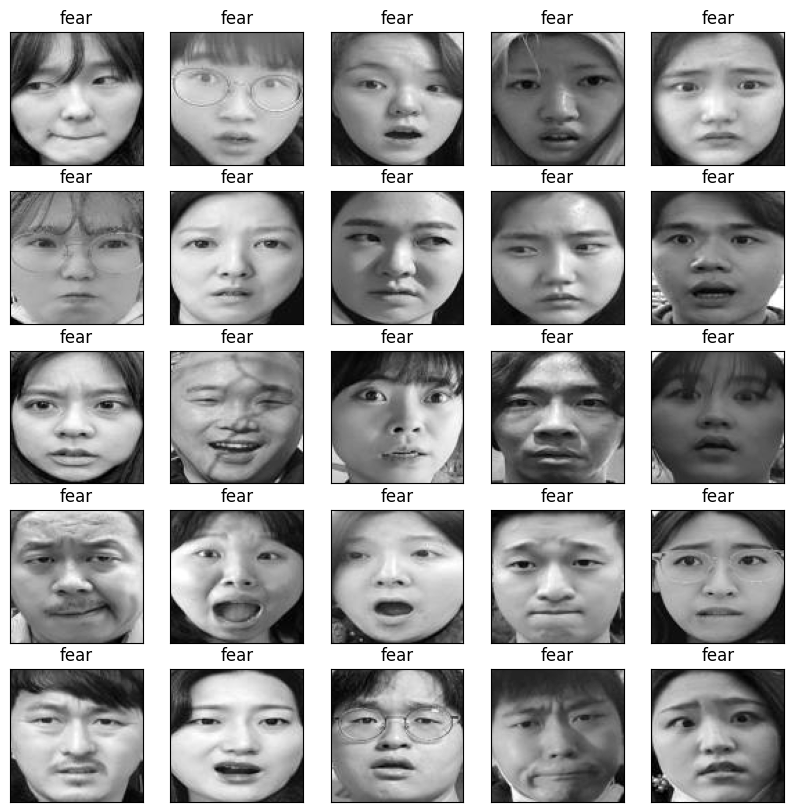

In [12]:
def show_one_emotion(images, labels, id, start=0, num=25):
    image_x = images[labels==id]
    label_x = labels[labels==id]
    show_images(image_x[start:start+num], label_x[start:start+num])

show_one_emotion(images, labels, id='1')

# **Split dataset**

In [13]:
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=0.2, random_state=42)

print('Training samples:', label_train.shape[0])
print('Validation samples:', label_val.shape[0])
print('Test samples:', label_test.shape[0])

Training samples: 271373
Validation samples: 67844
Test samples: 84805


# **Upsamling training data**

In [14]:
def upsampling(x, y, strategy):
    (n, w, h) = x.shape
    sm = SMOTE(sampling_strategy=strategy, random_state=42)
    x_flat = x.reshape((n,-1))
    x_up, y_up = sm.fit_resample(x_flat, y)
    n_up = x_up.shape[0]
    x_up = x_up.reshape((n_up,w,h))

    return x_up, y_up

In [15]:
collections.Counter(label_train)

Counter({'4': 78891, '1': 77436, '3': 38615, '2': 38397, '0': 38034})

In [16]:
#pickle 파일에서 데이터 로드
with open('./pickle_jar/image_train_up.pickle', 'rb') as file:
    image_train_up = pickle.load(file)
with open('./pickle_jar/label_train_up.pickle', 'rb') as file:
    label_train_up = pickle.load(file)

In [17]:
# image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

In [18]:
# # 데이터를 pickle 파일로 저장
# with open('./pickle_jar/image_train_up.pickle', 'wb') as file:
#      pickle.dump(image_train_up, file)
# with open('./pickle_jar/label_train_up.pickle', 'wb') as file:
#      pickle.dump(label_train_up, file)

In [19]:
collections.Counter(label_train_up)

Counter({'4': 78891, '3': 78891, '2': 78891, '1': 78891, '0': 78891})

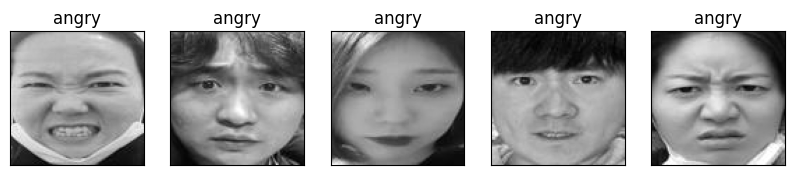

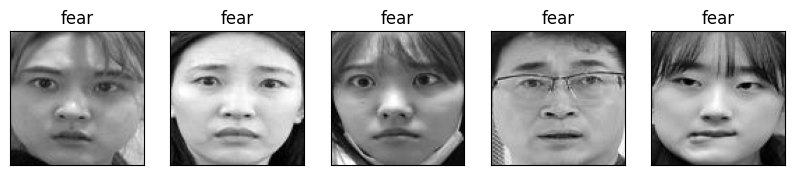

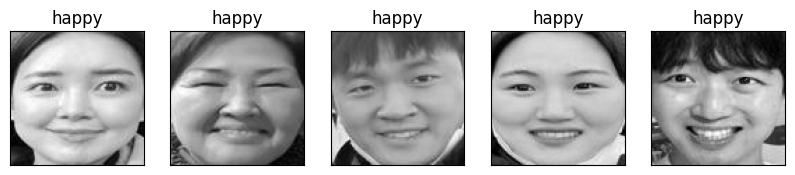

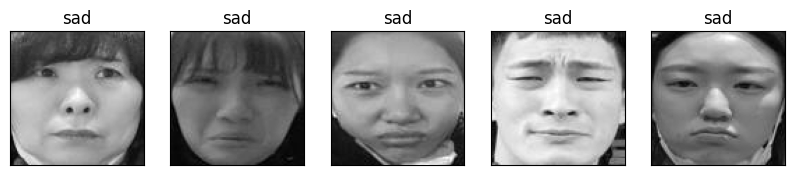

In [20]:
for i in range(num_classes):
    if i == 3:
        continue
    show_one_emotion(image_train_up, label_train_up, id=f'{i}', start=4000, num=5)

# **Utils**

In [21]:
def one_hot_encoding(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes)

In [22]:
def reshape_images(images, channel=1, resize=None):
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        x = tf.image.resize(x, resize)
    return x

In [23]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes)
    return x, y

In [24]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model '+name)
        plt.legend()
    plt.show()

In [25]:
def evaluate_class(model, x_test, y_test):
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    for i in range(num_classes):
        x = x_test[labels==i]
        y = y_test[labels==i]
        loss, acc = model.evaluate(x,  y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[f'{i}'], acc))
    print('-'*23)
    loss, acc = model.evaluate(x_test,  y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))

# **Model**

In [26]:
def model_checkpoint_cb(file_path):
    return ModelCheckpoint(
        file_path, monitor='val_loss', mode='min',
        save_best_only=True, save_weights_only=True,verbose = 1)

In [27]:
RESIZE = None
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes,resize = RESIZE)
x_val, y_val = pre_processing(image_val, label_val, num_classes,resize = RESIZE)
x_test, y_test = pre_processing(image_test, label_test, num_classes,resize = RESIZE)


train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

batch_size = 4
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape

In [28]:
class EmotionClassifier:
    def __init__(self, num_classes=5, checkpoint_path='./models/best_model.h5',input_shape = (96,96,1)):
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=self.input_shape)
        x = Flatten()(base_model.output)
        x = Dropout(0.2)(x)  # Apply dropout with rate 0.2 (keep probability 0.8) after the input layer.
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)  # Apply dropout with rate 0.5 (keep probability 0.5) for hidden layers.
        x = Dense(self.num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=x)
        return model

    def compile(self, learning_rate=1e-4):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def save(self):
        self.model.save_weights(self.checkpoint_path)

    def load(self):
        self.model.load_weights(self.checkpoint_path)

    def summary(self):
        self.model.summary()

    def train(self, train_generator, val_generator, epochs, steps_per_epoch, callbacks=[]):
        history = self.model.fit(
            train_generator,
            validation_data=val_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks
        )
        return history
    
    def evaluate(self, x_test, y_test, verbose=0):
        return self.model.evaluate(x_test, y_test, verbose=verbose)
    
    def predict(self, input_data):
        return self.model.predict(input_data)

In [29]:
tgram = Tgram()
# To display the model architecture

In [30]:
emotion_classifier = EmotionClassifier(num_classes=5, checkpoint_path='./models/best_model.h5')
emotion_classifier.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 47, 47, 32)   0           ['batch_normalization[0][0]']

In [31]:
emotion_classifier = EmotionClassifier(num_classes=5, checkpoint_path='./models/best_model.h5')
emotion_classifier.load()
# compile 메서드를 사용하여 모델 컴파일
emotion_classifier.compile(learning_rate=1.0000e-6)

# Setup callbacks
callbacks_list = [
    model_checkpoint_cb(emotion_classifier.checkpoint_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,min_lr=0, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
]

In [32]:
try:
    # Train the model
    history = emotion_classifier.train(
        train_generator=train_generator,
        val_generator=val_generator,
        epochs=300,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks_list
    )
except Exception as e:
    tgram.fail(e)
    raise KeyboardInterrupt

# After training, you might want to save the model
emotion_classifier.save()

Epoch 1/300
  278/98613 [..............................] - ETA: 1:11:32 - loss: 0.4609 - accuracy: 0.8264

KeyboardInterrupt: 

In [ ]:
plot_metrics(history)

In [34]:
# 모델 가중치 불러오기
emotion_classifier.load()

# 테스트 데이터셋을 사용하여 모델 성능 평가
x_test, y_test = pre_processing(image_test, label_test, num_classes=5)
evaluate_class(emotion_classifier, x_test, y_test)


Emotion        Accuracy
-----------------------
angry          70.6%
fear           76.2%
happy          96.9%
neutral        90.9%
sad            74.3%
-----------------------
Overall        79.9%


In [46]:
emotion_classifier.load()

# 예측을 위한 입력 데이터를 준비합니다. 예를 들어, (96, 96, 1) 크기의 이미지로 예를 들겠습니다.
# 여기서는 임의의 데이터로 예측을 시도합니다.
input_data = np.random.randn(1,96, 96, 1)
print(input_data.shape)
# 예측을 진행합니다.
predictions = emotion_classifier.predict(input_data)

# 가장 높은 확률을 가진 클래스의 인덱스를 가져옵니다.
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")

(1, 96, 96, 1)
1/1 [==============================] - 0s 17ms/step
Predicted class: 4


/home/sungwook/Desktop/bridze_cv


tgram.success()